table deleted


<IPython.core.display.Javascript object>


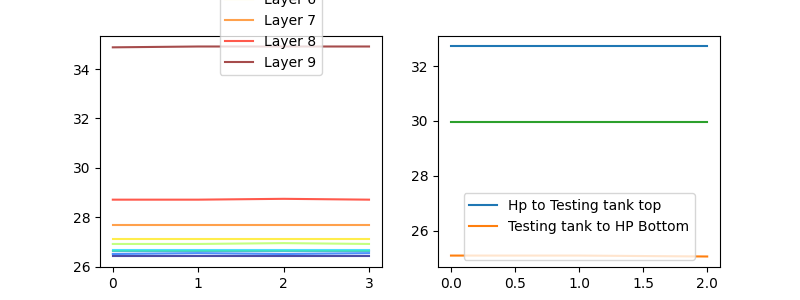

<IPython.core.display.Javascript object>


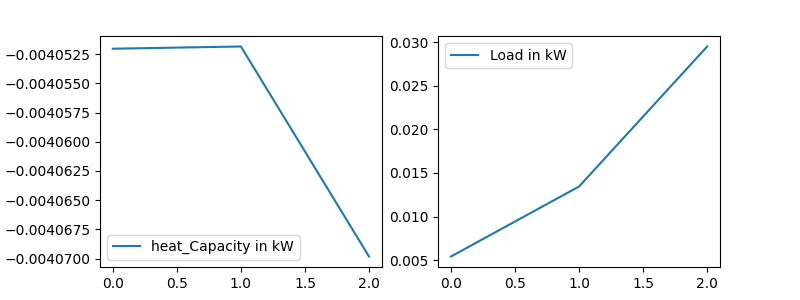

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


flow from FlowDB is : ((1, datetime.datetime(2021, 2, 17, 13, 7, 21), -0.463734, 0.534077),)
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((9021, datetime.datetime(2021, 2, 17, 12, 7, 19), 24.1446, 32.7113, 25.0916, 18.2993, 30.0679, 33.7625, 29.9662, 14.7565, 24.8887, 26.648, 26.6819, 26.5127, 26.6142, 26.4111, 34.8819, 28.7131, 27.6973, 27.1219, 26.9188),)
cop of system is: -0.7553739674373015
kwh heat addition is : -2.251131018989143e-06
electricity in khW is: 2.980154355367025e-06
cop of system is: -0.7553739674373015
kwh heat addition is : -2.251131018989143e-06
electricity in khW is: 2.980154355367025e-06
RangeIndex(start=0, stop=1, step=1)
________________________________________________________________
flow from FlowDB is : ((2, datetime.datetime(2021, 2, 17, 13, 7, 24), -0.463734, 1.32313),)
flow rates load is =  0.6340193487350078 0.0039770376912244875

KeyboardInterrupt: 

In [20]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque

import time
import struct
from struct import *
from pyModbusTCP.client import ModbusClient

#matplotlib.use('TkAgg')
%matplotlib notebook
#%matplotlib inline


#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY, ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, flowHP FLOAT, flowLoad FLOAT) ENGINE=MyISAM;')


#cvsFileName = import os.path
#os.path.exists(file_path)

lol=[[], [], [], []]
flowRateLoad  = []
wattMeterKw = []



def flatten(l_of_l):
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l




timePeriod = []
def timeStampCreator(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod.append(timeStamp)
    return 
    

def MCT_timeStamp(Lol, time_stamp):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    watt_kW = Lol[3]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    cop =mCT_kWh/watt_kWh
    print ('cop of system is:', cop)
    print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    #print ('electricity consumption kW :', watt_kW)
    return mCT_kW
    
def Cop(Lol, time_stamp):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    watt_kW = Lol[3]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    cop =mCT_kWh/watt_kWh
    print ('cop of system is:', cop)
    print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    #print ('electricity consumption kW :', watt_kW)
    return cop


l_id = []

def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMix','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    
    #print (df_mL)
    #print (df_mHP)
    #print (df_tem)
    #print ('TOut and Tin in Df is:', df_conc[['TTopTestTankLoadCir', 'TbottomTestTankLoadCir']])
    return df_conc

def list2df(lis, column_name = None):
    df  = pd.DataFrame(lis, columns = [column_name]) 
    return df
    
def toCsv(df_full, load_kW, heatCapacity_kW):
    df_Tem_Flow_Load_capacity_conc = pd.concat([df_full, load_kW, heatCapacity_kW], axis=1)
    import os.path
    import datetime
    file_name = 'csvFile_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    df_Tem_Flow_Load_capacity_conc.to_csv(filePath, header=True)
    return df_Tem_Flow_Load_capacity_conc

def Load_kWh(Lol):
    
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[10] - 8.42930922e-03*x[10]**2 + 6.77190849e-05*x[10]**3 \
 - 4.40840180e-07*x[10]**4 + 1.29302849e-09*x[10]**5 for x in T]
    #print ('denisty is:', p_LperH )
    #print ('Tem is:', [x[10] for x in T])
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mL)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[10] for b in T]
    #print ('Cp is:', cP_kjPerkgK)
    #Cp*M*deltaT
    load_mCT_kW = [c*a*(b[7]-b[10]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    #mCT2_kWh = sum([m*c*(dt[7]-dt[10])*0.0013888889 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    #load_mCT2_kWh = sum([m*c*(dt[7]-dt[10])*2.7777777e-05 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    #Time stamp uis 2 seconds 2* 1/3600
    load_mCT2_kWh = sum([m*c*(dt[7]-dt[10])*0.000555555556 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    #print ('Load in kWh is:', load_mCT2_kWh)
    return load_mCT_kW

def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT.columns)
    #print (dfT)
    dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')
    #dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T5', 'T6', 'T7', 'T8', 'T9']]
    #dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T8', 'T9', 'T5', 'T6', 'T7']]
    #dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T8':'T5', 'T9':'T6',\
    #           'T5':'T7','T6':'T8','T7':'T9'}, axis='columns')
    #dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T5':'T5', 'T6':'T6',\
    #          'T7':'T7','T8':'T8','T9':'T9'}, axis='columns')
    #dfT.columns = ['T4', 'T3', 'T2', 'T1', 'T0', 'T5', 'T6', 'T7', 'T8', 'T9']
    #print (dfT)
    return dfT
#tankStratTem = tankStrat(df_conc)

def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

#import logging
#logging.getLogger().setLevel(logging.CRITICAL)

# colors


cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)

plt.ion()
#plt.rcParams["figure.figsize"]=5,5
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 3
def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i))
        ax.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax.legend()
    #plt.legend(loc='upper left')
    return fig, ax
    
# initialize figure and interactivity
fig = plt.figure(1)
fig2 = plt.figure(2)


ax = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
ax2 = fig2.add_subplot(122)
ax2_1 = fig2.add_subplot(121)

fig.canvas.draw()
#plt.ion()

fig.show()

ax.legend(loc='best')
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')
#################################
#Plot for HPin, Hpout, TmixL tem.

fig.show()
fig.canvas.draw()
ax_2.legend(loc='best')
ax_2.set_xlabel('Index')
ax_2.set_ylabel('Load in kW', color='r')
def plotObject_Tem_HpAndLoad(df, ax_2, fig):
    ax_2.clear()
    ax_2.plot(df.index, df.iloc[:, 3], label = 'Hp to Testing tank top')
    ax_2.plot(df.index, df.iloc[:, 4], label = 'Testing tank to HP Bottom')
    ax_2.plot(df.index, df.iloc[:, 8], label = 'load tem Mixed')
    
    ax_2.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax_2.legend()
    #plt.legend(loc='upper left')
    return fig, ax_2
##################################

#fig2 = plt.figure(2)

#plt.ion()

fig2.show()
fig2.canvas.draw()
ax2.legend(loc='best')
ax2.set_xlabel('Index')
ax2.set_ylabel('Load in kW', color='r')
def plotObject_Load(df, ax2, fig2):
    ax2.clear()
    ax2.plot(df.index, df.iloc[:, -2], label = 'Load in kW')
    #ax2.plot(df.index, COP, label = 'cop')
    print (df.index)
    ax2.legend(bbox_to_anchor=(0.4,0.8))
    fig2.canvas.draw()
    ax2.legend()
    #plt.legend(loc='upper left')
    return fig2, ax2
    
# initialize figure and interactivity
####Plot for heat_Capacity:

fig2.show()
fig2.canvas.draw()
ax2_1.legend(loc='best')
ax2_1.set_xlabel('Index')
ax2_1.set_ylabel('Heat_Capacity in kW', color='r')
def plotObject_Heat_Capacity(df, ax2_1, fig2):
    ax2_1.clear()
    ax2_1.plot(df.index, df.iloc[:, -1], label = 'heat_Capacity in kW')
    ax2_1.legend(bbox_to_anchor=(0.4,0.8))
    fig2.canvas.draw()
    ax2_1.legend()
    #plt.legend(loc='upper left')
    return fig2, ax2_1
############

while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    
    ###################################################################################
    ################################################
    ##Modbus connection for wattmeter readings in kW
    ##https://stackoverflow.com/questions/28186746/python-convert-2-ints-to-float
    ################################################
    
    c = ModbusClient(host="10.208.8.125", port=502, auto_open=True)
    
    #This reads the register address 19026 where all teh meteric(values of wattmeter) 
    #values are stored in a 16 bit values.county = 2, means read two values in the
    #same register address.Register is a column (like in spreadsheet). each register
    #store a 16 bit value, we read two 16 bit value and would convert those 2 16 bit 
    #value to a 32 bit floating point value by the formula
    regs = c.read_input_registers(19026, 2)
    #this is forst value of two counts
    a = regs[0]
    #This is second value of two counts
    b = regs[1]
    #This is how we convert two 16 bit value to a single 32 floating point number.
    #from stackoverflow
    mypack = pack('>HH',a,b)
    #print (mypack)
    fl = unpack('>f', mypack)
    #fl = struct.unpack('!f', bytes.fromhex('{0:02x}'.format(a) + '{0:02x}'.format(b)))
    #fl is a tuple (5.0186,) I need to unpack it index it with [0] 
    fl = fl[0]*10**-3
    wattMeterKw.append(fl)
    #lol[3].append(fl)
    #print ('watter meter reaidngs are:', wattMeterKw)
    #print ('gross lol is:', lol)
    ####################################################################################
    
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(%s, %s)", (flow2, flow1))
    connectionL.commit()
    
    #cL =connectionL.cursor()
    cL.execute("SELECT * FROM flowReadings ORDER BY id DESC LIMIT 1")
    FlowFormDb = cL.fetchall()
    print ('flow from FlowDB is :',FlowFormDb)
    #c.execute("SELECT * from temSensor")
    #cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    #result = cR.fetchall()
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    print ('result is',result)
    id = result[0][0]
    #idGenerator(id, l_id)
    #print ('id is :', id)
    flowRateLoad.append(flow1)

    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        lol[1].append(flow1)
        lol[2].append(flow2)
        lol[3].append(fl)
        timeStampCreator(lol)
    elif lol[0] != [] and id > lol[0][-1][0][0]:

        lol[0].append(result)
        lol[1].append(flow1)
        lol[2].append(flow2)
        lol[3].append(fl)
        timeStampCreator(lol)


    #mct(lol)
    #Load = Load_kWh(lol)
    #print ('load in kWh is:', Load)
    #print ('lol is:',lol)
    #print ('df of tem is:',df_tem)
    #print ('df is:', tankStrat(dfs(lol)))
    df = tankStrat(dfs(lol))
    #restTem = InletTem(dfs(lol))
    #print (df)
    
    cop = Cop(lol, timePeriod)
    
    GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol), 'Load_kW'), list2df(MCT_timeStamp(lol, timePeriod),'Heat_Capacity_kW'))
    #heatAddition_kwh, cop = MCT_timeStamp(lol, timePeriod)
    # Plot tem values as a seperate first fig
    fig, ax = plotObject(df, ax,  fig, alpha=0.7, scm=scm)
    #plot load_kW in different fig2 
    fig2, ax2 = plotObject_Load(GrossDf, ax2, fig2)
    #Plot heat_Capacity in the same fig as fig2 but as a subplot
    fig2, ax2_1 =plotObject_Heat_Capacity(GrossDf, ax2_1, fig2)
    #This plot the HP in and out and tmixL laod tem.
    fig, ax_1 = plotObject_Tem_HpAndLoad(GrossDf, ax_2, fig)
    
    #print ('df whole is:', dfs(lol))
    #print ('df is:', df)
    #plot(tankStrat(dfs(lol)), plotObject(tankStrat(dfs(lol))))
    #plotObject(tankStrat(dfs(lol)))for i in range (0, 10):
    #x = tankStrat(dfs(lol)).index[-1]
    #y =tankStrat(dfs(lol)).iloc[-1]
    #print ('x is:',x,'y is :',y)
    #restTem = InletTem(dfs(lol))
    #print ('rets of inlet tem values are:', restTem.iloc[:, 1])
    #print ('gross lol is:', lol)
    #print ('values in teh list are:', lol[0][-1][0][0])
    #print ('GrossDf is :', GrossDf.iloc[:, 0:2])
    #print ('grand lollolo is :', lol)
    #MCT_timeStamp(lol)
    #timeStampCreator(lol)
    #MCT_timeStamp(lol, timePeriod)
    
    #print ('time stamp list is :',timePeriod )
    print('________________________________________________________________')
    time.sleep(0.1)

In [ ]:
#store the wattmeter values in databse to know their timestamp
#plot lagtest kw heat addition [-1 ] to see why its so much fluctuating, plot latest flow rate[-1]
#plot latest kW of electricty too
#Hp Documenyt says: rated input - 1.27kWh for 6.08kWh of output energy at 50rps so seems ok for now
#Its dependent on time, lower gives lower kwh heat addition, whigher gives higher. 
#Something is wrong in the formulae of heat additon in kWh
# sum() function is not summing everything behind its summing something else, check it =

In [ ]:
#print last kw heat addition to see if its negative as its still fluctuating